<a href="https://colab.research.google.com/github/pinkett35/Quantum-KNN/blob/main/Quantum_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit

In [3]:
##Importing libraries 
import numpy as np
from keras.datasets import mnist
from qiskit import *
from matplotlib import pyplot as plt 
import tensorflow as tf
import collections
from qiskit.circuit import QuantumRegister,ClassicalRegister,QuantumCircuit
from qiskit.extensions import UnitaryGate


Step #1 Load data set as quantum information

11493376/11490434 [==============================] - 0s 0us/step
True
True


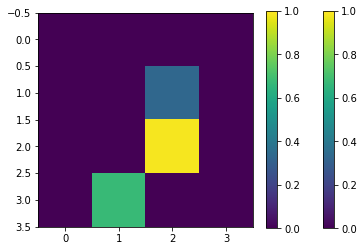

In [4]:
#Loading the dataset 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

#print("Number of filtered training examples:", len(x_train))
#print("Number of filtered test examples:", len(x_test))

print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()
##Tuple of nd.arrays 
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    #print("Number of unique images:", len(mapping.values()))
    #print("Number of unique 3s: ", num_uniq_3)
    #print("Number of unique 6s: ", num_uniq_6)
    #print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    #print()
    #print("Initial number of images: ", len(xs))
    #print("Remaining non-contradicting unique images: ", len(new_x))

    #print("New x values", np.array(new_x))
    return np.array(new_x), np.array(new_y)


x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)


Auto encode data onto quantum states to prepare for quantum circuit. 

In [ ]:
###Auto-encoder 
##Encoding class to encode quantum data 
class EncodeUnitaryMatrix():
    def __init__(self,data):
        self.data = data
    # Check if a matrix is unitary using this function
    def is_unitary(self,m):
        return np.allclose(np.eye(len(m)), m.dot(m.T.conj()))
    def to_unitary_matrix(self):
        qm = self.toQuantumMatrix(self.data)
        qv =self.toQuantumData(self.data)
        self.data_matrix = np.array(qm)
        self.data_vector = np.array(qv)
    # Converting classical data to quantum data
    def toQuantumData(self,data):
        input_vec = data.copy().ravel()
        vec_len = input_vec.shape[0]
        input_matrix = np.zeros((vec_len, vec_len))
        input_matrix[0] = input_vec
        input_matrix = np.float64(input_matrix.transpose(0, 1))
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = np.dot(u, v)
        output_matrix = output_matrix
        output_data = output_matrix[0, :]
        print(output_data)
        return output_data
    # Converting classical data to quantum matrix
    def toQuantumMatrix(self,data):
        input_vec = data.flatten()
        vec_len = input_vec.shape[0]
        input_matrix = np.zeros((vec_len,vec_len))
        input_matrix[0] = input_vec
        input_matrix = input_matrix.T
        u, s, v = np.linalg.svd(input_matrix)
        output_matrix = np.dot(u, v)
        return output_matrix
    def get_data(self):
        return self.data
    def get_unitary_gate(self):
        self.to_unitary_matrix()
        return self.data_matrix
    def get_quantum_data(self):
        self.to_unitary_matrix()
        return self.data_vector
data = EncodeUnitaryMatrix(x_train_nocon[0])
conv_data_matrix,conv_data_statevector = (data.get_unitary_gate(),data.get_quantum_data)

list_of_points = []
for datapoint in x_train_nocon:
    conv_data_matrix = EncodeUnitaryMatrix(datapoint).get_unitary_gate()
    list_of_points.append(conv_data_matrix)

In [ ]:
# Load data, resize data , call Sam's encoded function for the quantum circuit, use swap test at

Applying RY gate to circuit. 

In [6]:
def RY(circuit,values):
  for i,val in enumerate(values):
    circuit.ry(val,i+1)

def CRY(circuit,values):
  for i in range(len(values)):
    if i == len(values):
      circuit.cry(values[-1],i+2, i+2)
    circuit.cry(values[i],i+1, i+2)

Apply CRY gate to circuit.  

In [15]:
import cv2
import qiskit
import copy
from qiskit.extensions import XGate, UnitaryGate
import matplotlib.pyplot as plt
#data being applied to encode unitary matrix
data = EncodeUnitaryMatrix(x_train_nocon)
##data matrix
#conv_data_matrix,conv_data_statevector = (data.get_unitary_gate(),data.get_quantum_data)
##Shape of data matrix
###Take a data point
#Variable bank (random array multiplied by pi, 16 by 16)
variables = [np.random.rand()*np.pi for _ in range(16)]
##Takes a data point and matrix and applies a circuit
def encode_circuit_init(variables, conv_data_matrix):
#Qubit register
  qubits = QuantumRegister(9)
#Classical register
  cbits = ClassicalRegister(1)
## Builds the Circuit
  circ = QuantumCircuit(qubits)
  circ.add_register(cbits)
##Appending the unitary gate to the circuit
  circ.append(UnitaryGate(conv_data_matrix),qubits[1:5])
  circ.append(UnitaryGate(conv_data_matrix),qubits[5:9])
##Applying the RY and CRY function
  RY(circ, variables[0:4])
  CRY(circ,variables[5:9])
##Resetting the first and second qubit
  circ.reset(1)
  circ.reset(2)
##Applying the RY and CRY function
  RY(circ, variables[8:12])
  CRY(circ, variables[12:16])
  circ.h(0)
  sim = Aer.get_backend('qasm_simulator')
  [circ.cswap(0,i+1,i+5) for i in range(4)]
  circ.h(0)
  circ.measure(0,0)

  return circ

##print(circ.draw())
x = print(encode_circuit_init(variables, conv_data_matrix))


'''
#Variable for simulator
simulator = Aer.get_backend('qasm_simulator')

##Function : Calculates Quantum Fidelity from circuit and data matrix
def get_probabilities(circ,counts=7500):
    job = execute(circ, backend = simulator , shots=counts)
    results = job.result().get_counts(circ)
    try:
        prob = results['0']/(results['1']+results['0'])
        prob = (prob-0.5)
        if prob <= 0.005:
            prob = 0.005
        else:
            prob = prob*2
    except:
        prob = 1
    return prob
##Function purpose: Loops over data points and retrieves gradient from circuit and data matrix
list_of_points = list_of_points[:5]
iterations = []
total_iter = 0 
#Looping 50 times
for epoch in range(0, 3):
    avg_fidelity = []
#Loop over data points
    for data in list_of_points:
        ## Loops over variable bank
        for j in range(len(variables)):
            ##Copies over variable bank
            theta = copy.deepcopy(variables)
            theta_1,theta_2 = theta,theta
            #Stores theta values
            theta_1[j] += np.pi/2
            theta_2[j] -= np.pi/2
            ##Appends theta values to list to apply to gate
            ##Build circuit 1 with theta variable measure fidelity
            circuit1 = get_probabilities(encode_circuit_init(theta_1 , data))
            #print(encode_circuit_init(theta_2 , conv_data_matrix))
            ##Build circuit 2 measure fidelity
            circuit2 = get_probabilities(encode_circuit_init(theta_2 , data))
            ##Gradient = fidelity(circuit 1) - fidelity(circuit 2) / 2
            gradient = (circuit1 - circuit2) / 2
            #print("Gradient {}".format(gradient))
            ## Updating values in variable bank
            variables[j] += gradient * 0.4
            print(f"Gate {j} Updated by {gradient*0.4}")
            if epoch%2==0 and epoch<4:
                avg_fidelity.append(get_probabilities(encode_circuit_init(variables , conv_matrix_data)))
            total_iter += 1
            iterations.append(total_iter)
            
print(f"Average Fidelity: {np.mean(avg_fidelity)}")
#print(avg_fidelity)
print(total_iter)
print(iterations)

###Graphing the Quantum Fidelity 
x = np.array(iterations)
##Reshape to take first 80 iterations
x.resize(80)

##Stores the average fidelity 
y = np.array(avg_fidelity)

plt.title("Average Quantum Fidelity")
plt.xlabel("Iterations")
plt.ylabel("Average Fidelity")
plt.plot(x, y)'''





         ┌───┐                                                             »
q8_0: ───┤ H ├─────────────────────────────────────────────────────────────»
      ┌──┴───┴───┐┌─────────────┐                            ┌────────────┐»
q8_1: ┤0         ├┤ RY(0.27887) ├──────■────────────|0>──────┤ RY(2.0115) ├»
      │          │└┬────────────┤┌─────┴──────┐              └────────────┘»
q8_2: ┤1         ├─┤ RY(2.5288) ├┤ RY(1.0237) ├──────■────────────|0>──────»
      │  unitary │ ├────────────┤└────────────┘┌─────┴──────┐              »
q8_3: ┤2         ├─┤ RY(2.4864) ├──────────────┤ RY(2.1214) ├──────■───────»
      │          │ ├────────────┤              └────────────┘┌─────┴──────┐»
q8_4: ┤3         ├─┤ RY(2.2897) ├────────────────────────────┤ RY(1.8147) ├»
      ├──────────┤ └────────────┘                            └────────────┘»
q8_5: ┤0         ├─────────────────────────────────────────────────────────»
      │          │                                                         »

'\n#Variable for simulator\nsimulator = Aer.get_backend(\'qasm_simulator\')\n\n##Function : Calculates Quantum Fidelity from circuit and data matrix\ndef get_probabilities(circ,counts=7500):\n    job = execute(circ, backend = simulator , shots=counts)\n    results = job.result().get_counts(circ)\n    try:\n        prob = results[\'0\']/(results[\'1\']+results[\'0\'])\n        prob = (prob-0.5)\n        if prob <= 0.005:\n            prob = 0.005\n        else:\n            prob = prob*2\n    except:\n        prob = 1\n    return prob\n##Function purpose: Loops over data points and retrieves gradient from circuit and data matrix\nlist_of_points = list_of_points[:5]\niterations = []\ntotal_iter = 0 \n#Looping 50 times\nfor epoch in range(0, 3):\n    avg_fidelity = []\n#Loop over data points\n    for data in list_of_points:\n        ## Loops over variable bank\n        for j in range(len(variables)):\n            ##Copies over variable bank\n            theta = copy.deepcopy(variables)\n 

In [ ]:
x = np.array(iterations)
x.resize(80)
y = np.array(avg_fidelity)
print(y)

